In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

In [58]:
class SymbolCNN(nn.Module):
    def __init__(self):
        super(SymbolCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # Output: (32, 18, 18)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)  # Output: (64, 16, 16)
        self.pool = nn.MaxPool2d(2, 2)  # Output: (64, 8, 8)

        self.flattened_size = 64 * 8 * 8
        self.fc_symbol = nn.Linear(self.flattened_size, 8)
        self.fc_indicator = nn.Linear(self.flattened_size, 1)

    def forward(self, x):
        features_1 = F.relu(self.conv1(x))
        features_2 = self.pool(F.relu(self.conv2(features_1)))
        flattened_features = features_2.view(features_2.size(0), -1)

        symbol_out = self.fc_symbol(flattened_features)
        indicator_out = torch.sigmoid(self.fc_indicator(flattened_features))

        return symbol_out, indicator_out, features_2  # Return intermediate features


In [59]:
class PairedSlotMachineEnv(gym.Env):
    def __init__(self):
        super(PairedSlotMachineEnv, self).__init__()

        # Define action space: pick option 1 or option 2 in the current pair
        self.action_space = spaces.Discrete(2)
        
        # Observation space: represent each machine with its index and indicator status (0 or 1)
        self.observation_space = spaces.MultiDiscrete([8, 2, 8, 2])

        # Define slot machine points and probabilities
        self.points = {
            'A': 10, 'B': 10, 'C': 1, 'D': 1,
            'E': 10, 'F': 10, 'G': 1, 'H': 1
        }
        self.probabilities = {
            'A': 0.75, 'B': 0.25, 'C': 0.75, 'D': 0.25,
            'E': 0.75, 'F': 0.25, 'G': 0.75, 'H': 0.25
        }

        # Image paths for each symbol
        self.images = {
            "A": {"woSymbol": "./ResizedSymbols/SymbolA.png", "wSymbol": "./ResizedSymbols/SymbolA_R.png"},
            "B": {"woSymbol": "./ResizedSymbols/SymbolB.png", "wSymbol": "./ResizedSymbols/SymbolB_R.png"},
            "C": {"woSymbol": "./ResizedSymbols/SymbolC.png", "wSymbol": "./ResizedSymbols/SymbolC_R.png"},
            "D": {"woSymbol": "./ResizedSymbols/SymbolD.png", "wSymbol": "./ResizedSymbols/SymbolD_R.png"},
            "E": {"woSymbol": "./ResizedSymbols/SymbolE.png", "wSymbol": "./ResizedSymbols/SymbolE_R.png"},
            "F": {"woSymbol": "./ResizedSymbols/SymbolF.png", "wSymbol": "./ResizedSymbols/SymbolF_R.png"},
            "G": {"woSymbol": "./ResizedSymbols/SymbolG.png", "wSymbol": "./ResizedSymbols/SymbolG_R.png"},
            "H": {"woSymbol": "./ResizedSymbols/SymbolH.png", "wSymbol": "./ResizedSymbols/SymbolH_R.png"},
        }

        # Original pairs for Learning Phase and new pairs for Transfer Phase
        self.learning_pairs = [('A', 'B'), ('C', 'D'), ('E', 'F'), ('G', 'H')]
        self.transfer_pairs = [('A', 'C'), ('B', 'D'), ('E', 'H'), ('F', 'G')]
        self.transfer_phase = False  # Start in learning phase by default
        self.current_pair = None
        self.rewards = None
        self.indicators = None

        self.transform = transforms.Compose([
            transforms.Resize((20, 20)),  # Resize to 20x20
            transforms.ToTensor(),       # Convert to tensor
        ])

        # Load the trained model
        self.model = SymbolCNN()
        self.model.load_state_dict(torch.load("symbol_cnn.pth"))  # Replace with your saved model path
        self.model.eval()

        # Initialize logs to track each action taken by the agent
        self.logs = []

    def set_transfer_phase(self, transfer: bool):
        """Toggle between learning and transfer phases."""
        self.transfer_phase = transfer

    def reset(self, seed=None):
        super().reset(seed=seed)
        # Start with a random pair from the current phase
        self.current_pair = self._get_random_pair()
        # Set up the initial observation with pre-sampled rewards and indicators
        return self._get_observation(), {}

    
    
    def _get_machine_index(self, machine):
        # Map machine labels to indices for the observation space
        machine_indices = {'A': 0, 'B': 1, 'C': 2, 'D': 3,
                           'E': 4, 'F': 5, 'G': 6, 'H': 7}
        return machine_indices[machine]

    def _get_random_pair(self):
        # Select from learning pairs or transfer pairs based on the phase
        pairs = self.transfer_pairs if self.transfer_phase else self.learning_pairs
        pair = pairs[np.random.randint(len(pairs))]
        # Randomly shuffle the order with 50% probability
        if np.random.rand() < 0.5:
            pair = pair[::-1]
        return pair

    def _get_indicator_status(self, reward_given):
        # 95% chance of showing the indicator if reward is given, or hiding it if not
        if reward_given:
            return 1 if np.random.rand() < 0.95 else 0
        else:
            return 0 if np.random.rand() < 0.95 else 1
        
    def _get_img_path(self, reward_given, machine):
        if reward_given:
            return self.images[machine]['wSymbol'] if np.random.rand() < 0.95 else self.images[machine]['woSymbol']
        else:
            return self.images[machine]['woSymbol'] if np.random.rand() < 0.95 else self.images[machine]['wSymbol']
        
    # Function to make a prediction
    def _predict_image(self, model, image_path):
        # Load the image
        image = Image.open(image_path).convert('L')  # Convert to grayscale

        # Apply preprocessing
        image_tensor = self.transform(image).unsqueeze(0)  # Add batch dimension

        # Pass the image through the model
        with torch.no_grad():  # No gradient calculation needed
            symbol_out, indicator_out, _ = model(image_tensor)

        # Decode the predictions
        symbol_index = torch.argmax(symbol_out, dim=1).item()  # Get the index of the highest score
        indicator_pred = (indicator_out > 0.5).item()          # Threshold at 0.5 for binary output

        # Map symbol index to the corresponding label
        #symbols = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']  # Replace with your symbol mapping
        #symbol = symbols[symbol_index]

        # Return predictions
        return {'symbol': symbol_index, 'indicator': int(indicator_pred)}


    def _get_observation(self):
        # Generate machine indices for the current pair
        #machine_indices = [self._get_machine_index(m) for m in self.current_pair]
        machine_indices = []

        # Sample rewards and indicator statuses once, store them in instance variables
        self.rewards = []
        self.indicators = []
        
        for i, machine in enumerate(self.current_pair):
            reward_given = np.random.rand() < self.probabilities[machine]
            reward = self.points[machine] if reward_given else 0
            self.rewards.append(reward)
            path = self._get_img_path(reward_given, machine)
            symbol = self._predict_image(self.model, path)
            machine_indices.append(symbol['symbol'])
            #indicator = self._get_indicator_status(reward_given)
            self.indicators.append(symbol['indicator'])

        # Return observation as [machine index, indicator] pairs
        return np.array([machine_indices[0], self.indicators[0], machine_indices[1], self.indicators[1]])

    def step(self, action):
        # Use the pre-sampled reward for the selected action
        reward = self.rewards[action]
        
        # Log the outcome in the desired format
        log_entry = {
            'pair': ''.join(self.current_pair),
            'lSymbol': self.current_pair[0],
            'rSymbol': self.current_pair[1],
            'lIndicator': bool(self.indicators[0]),
            'rIndicator': bool(self.indicators[1]),
            'symbolPicked': self.current_pair[action]
        }
        self.logs.append(log_entry)
        
        # Select a new random pair for the next step
        self.current_pair = self._get_random_pair()
        
        # Get the new observation (with updated pre-sampled rewards and indicators)
        observation = self._get_observation()
        return observation, reward, False, False, {}

    def render(self):
        print(f"Current pair: {self.current_pair[0]} (with indicator {self.indicators[0]}) "
              f"vs {self.current_pair[1]} (with indicator {self.indicators[1]})")

    def get_logs(self):
        # Return the full log for analysis
        return self.logs


In [60]:
def plot_choices_over_time(df, pair, lSymbol, rSymbol):
    # Filter data for the specific pair and both positions
    pair_df = df[(df['pair'] == pair)]

    # Iterate over all indicator combinations
    indicator_combinations = pair_df[['lIndicator', 'rIndicator']].drop_duplicates()

    for _, comb in indicator_combinations.iterrows():
        l_ind = comb['lIndicator']
        r_ind = comb['rIndicator']
        
        # Filter for the specific indicator combination
        subset = pair_df[(pair_df['lIndicator'] == l_ind) & (pair_df['rIndicator'] == r_ind)]

        # Calculate cumulative counts for each symbol
        subset['time'] = range(len(subset))  # Add a time step column
        cumulative_counts = subset.groupby('time')['symbolPicked'].value_counts().unstack(fill_value=0).cumsum()

        # Plot the cumulative counts
        plt.figure(figsize=(10, 6))
        for symbol in [lSymbol, rSymbol]:
            plt.plot(cumulative_counts.index, cumulative_counts[symbol], label=f'Symbol {symbol}')

        # Add labels, title, and legend
        plt.title(f"Choices over Time for Pair {pair} (lIndicator={l_ind}, rIndicator={r_ind})")
        plt.xlabel("Time Step")
        plt.ylabel("Cumulative Count of Choices")
        plt.legend()
        plt.grid()
        plt.show()
        plt.close()  # Ensure the plot does not overlap in Jupyter

In [61]:
# Initialize the environment
env = PairedSlotMachineEnv()
check_env(env)

# Create the PPO model
model = PPO("MlpPolicy", env, verbose=1, gamma=1)

# Train the model
model.learn(total_timesteps=200000)


C:\Users\Prod\AppData\Local\Temp\ipykernel_11172\470276357.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load("symbol_cnn.pth"))  # R

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 182  |
|    iterations      | 1    |
|    time_elapsed    | 11   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 2           |
|    time_elapsed         | 25          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010964971 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.685      |
|    explained_variance   | -0.00167    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.05e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0183     |
|    value_loss        

200715
  pair lSymbol rSymbol  lIndicator  rIndicator symbolPicked
0   BA       B       A       False       False            B
1   HG       H       G       False        True            H
2   CD       C       D        True       False            C
3   HG       H       G       False       False            G
4   CD       C       D        True        True            D
5   BA       B       A        True        True            A
6   EF       E       F        True       False            E
7   BA       B       A       False       False            B
8   HG       H       G        True        True            G
9   EF       E       F        True        True            E


C:\Users\Prod\AppData\Local\Temp\ipykernel_11172\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


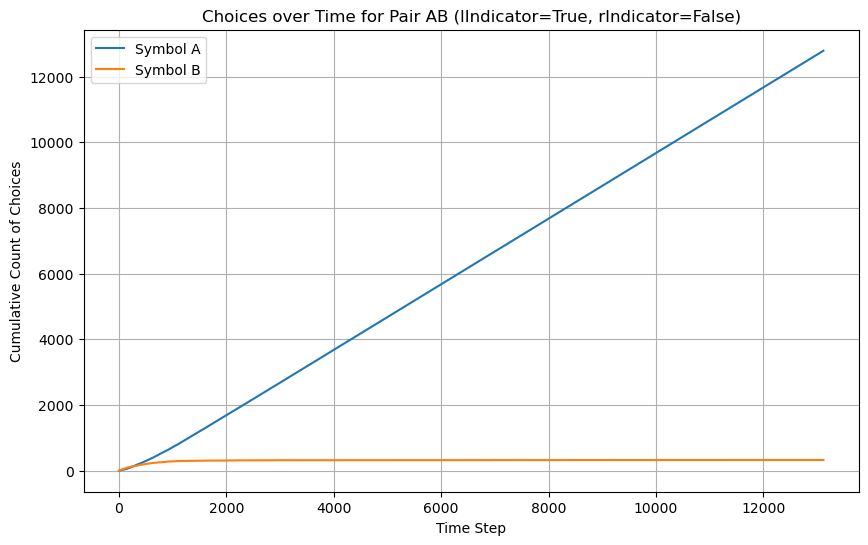

C:\Users\Prod\AppData\Local\Temp\ipykernel_11172\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


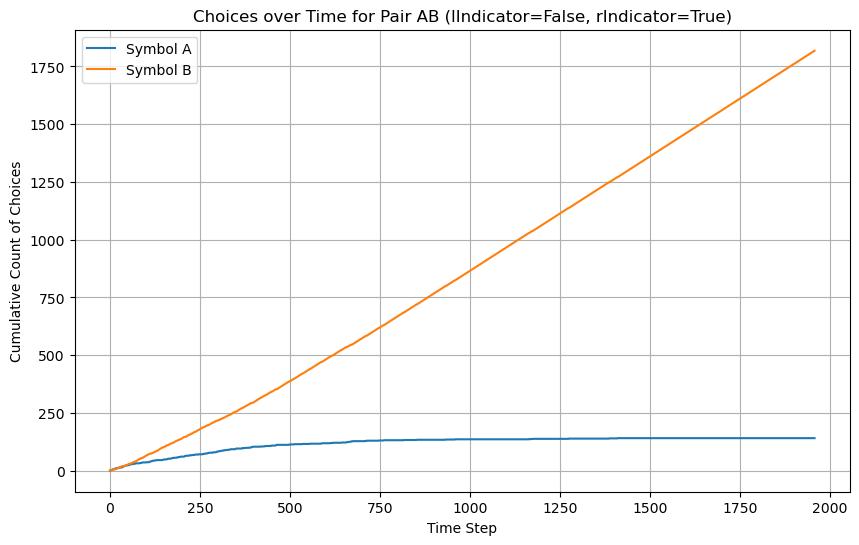

C:\Users\Prod\AppData\Local\Temp\ipykernel_11172\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


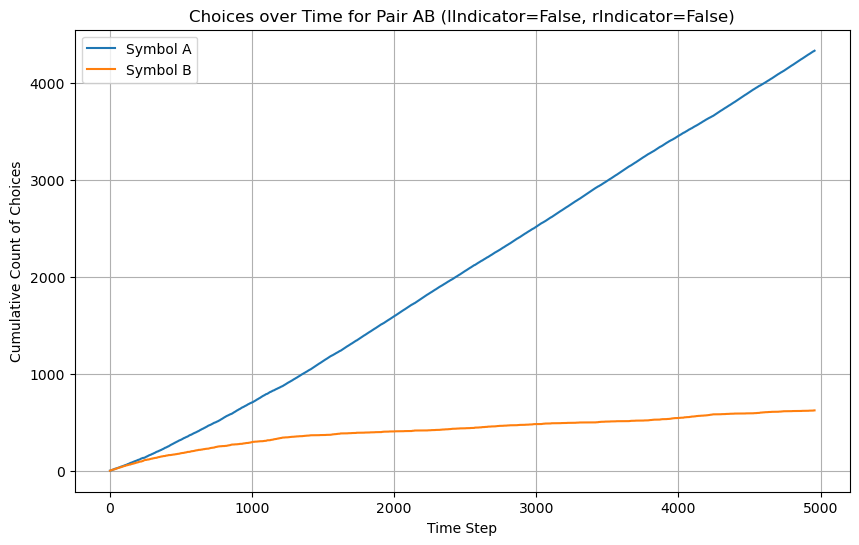

C:\Users\Prod\AppData\Local\Temp\ipykernel_11172\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


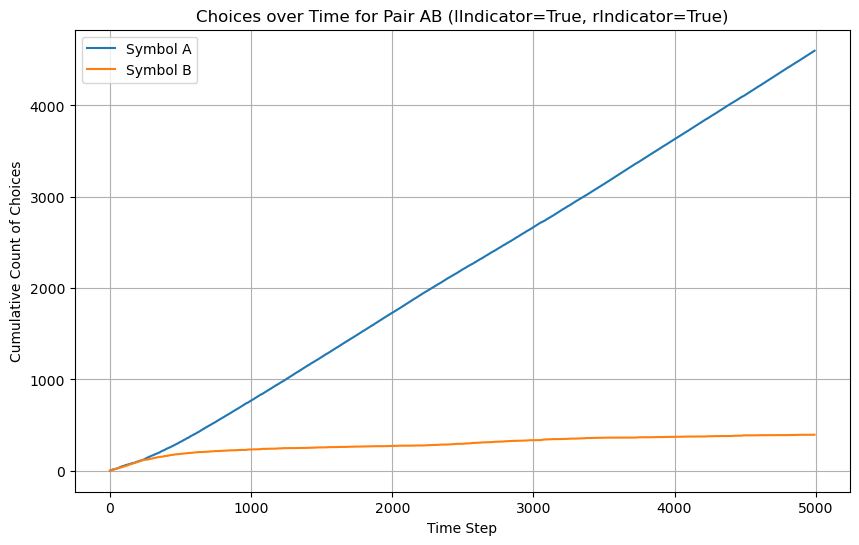

C:\Users\Prod\AppData\Local\Temp\ipykernel_11172\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


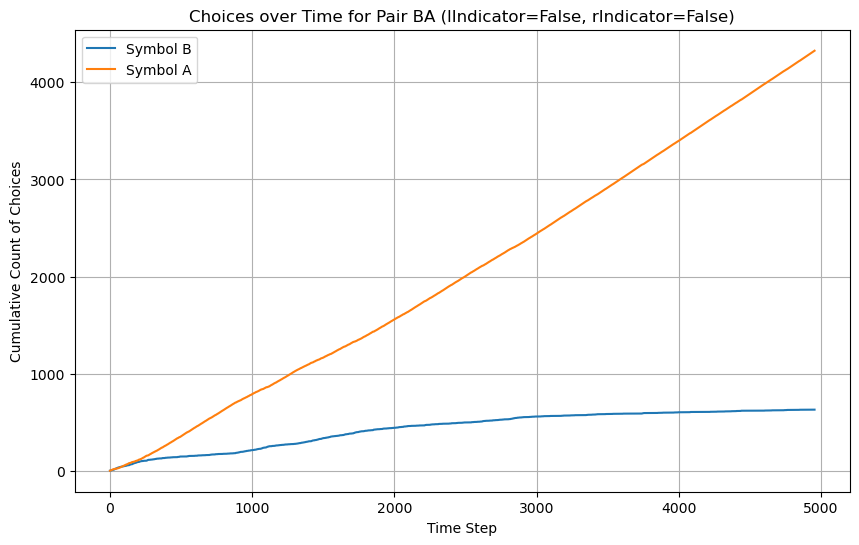

C:\Users\Prod\AppData\Local\Temp\ipykernel_11172\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


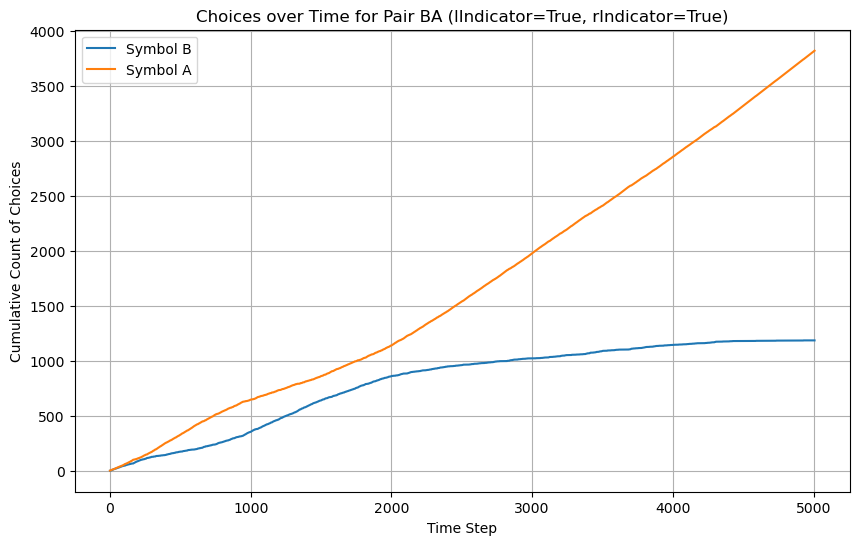

C:\Users\Prod\AppData\Local\Temp\ipykernel_11172\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


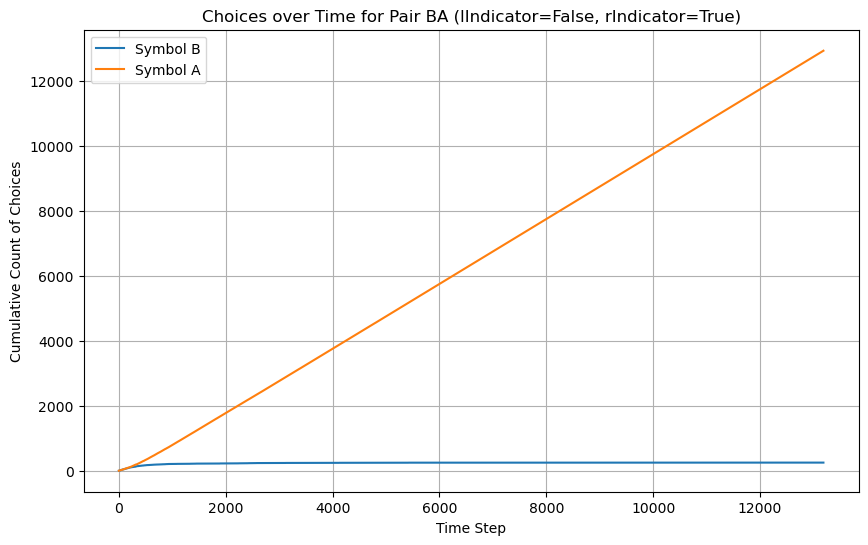

C:\Users\Prod\AppData\Local\Temp\ipykernel_11172\4056639254.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['time'] = range(len(subset))  # Add a time step column


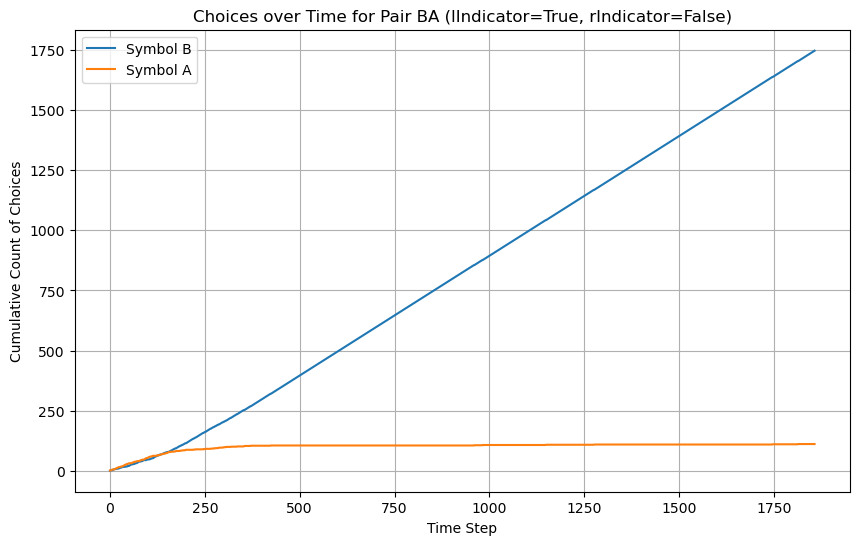

In [62]:
logs = env.get_logs()
logs = pd.DataFrame(logs)
print(len(logs))
print(logs.iloc[0:10])

# Plot choices for pair 'AB' where A and B switch positions
plot_choices_over_time(logs, pair='AB', lSymbol='A', rSymbol='B')
plot_choices_over_time(logs, pair='BA', lSymbol='B', rSymbol='A')

In [63]:
# Count the number of times each pair showed up in each configuration
pair_config_counts = logs.groupby(['pair', 'lSymbol', 'rSymbol', 'lIndicator', 'rIndicator']).size().reset_index(name='count')

# Display the results
print(pair_config_counts)


   pair lSymbol rSymbol  lIndicator  rIndicator  count
0    AB       A       B       False       False   4959
1    AB       A       B       False        True   1959
2    AB       A       B        True       False  13118
3    AB       A       B        True        True   4993
4    BA       B       A       False       False   4955
5    BA       B       A       False        True  13187
6    BA       B       A        True       False   1858
7    BA       B       A        True        True   5008
8    CD       C       D       False       False   5006
9    CD       C       D       False        True   1911
10   CD       C       D        True       False  13049
11   CD       C       D        True        True   4892
12   DC       D       C       False       False   4918
13   DC       D       C       False        True  13101
14   DC       D       C        True       False   1860
15   DC       D       C        True        True   5061
16   EF       E       F       False       False   5065
17   EF   

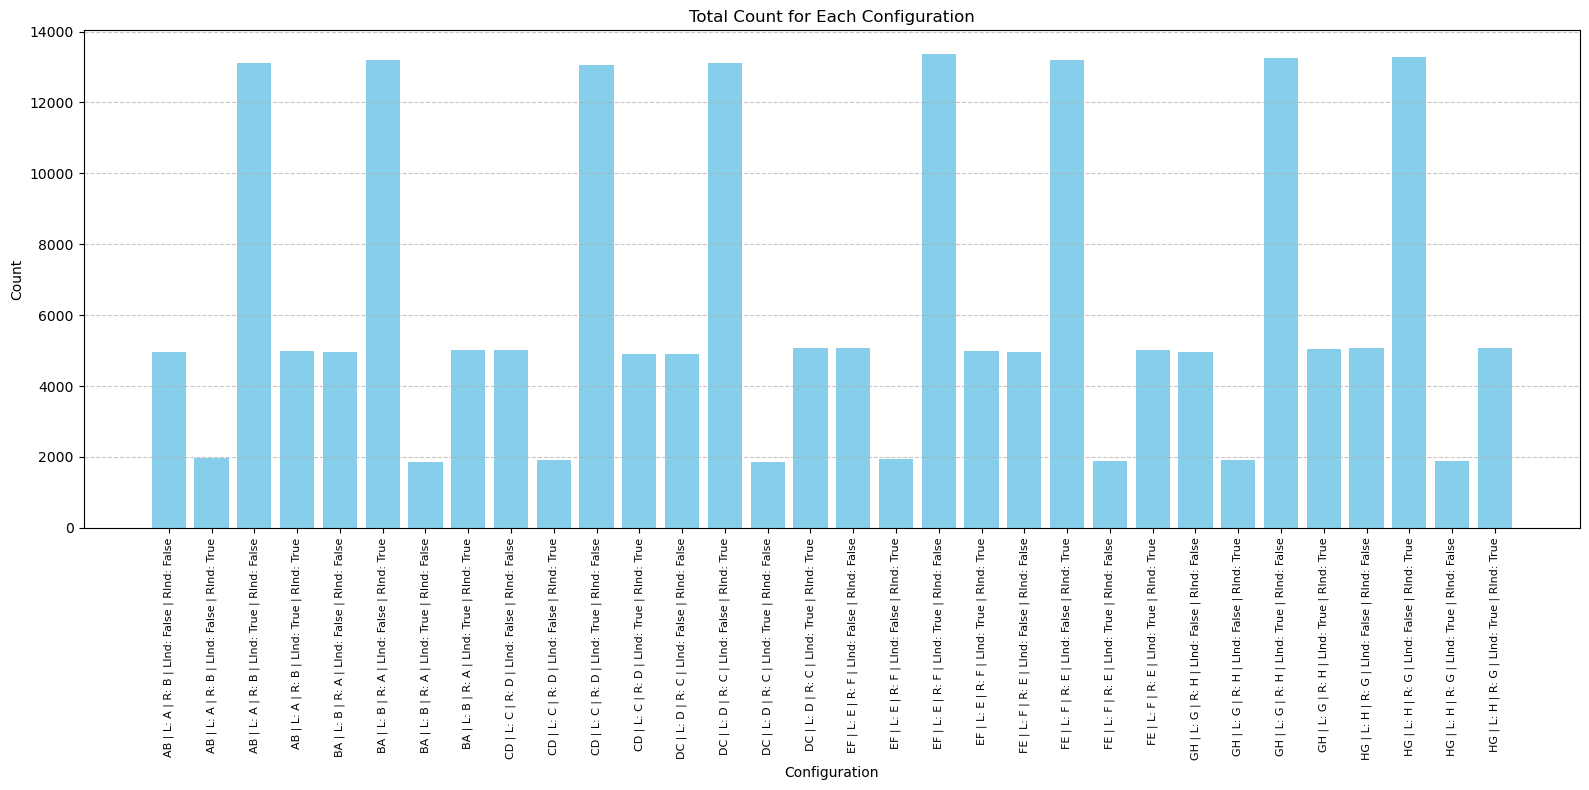

In [64]:
# Create a column for configuration labels for easier plotting
pair_config_counts['configuration'] = (
    pair_config_counts['pair'] + 
    " | L: " + pair_config_counts['lSymbol'] + 
    " | R: " + pair_config_counts['rSymbol'] + 
    " | LInd: " + pair_config_counts['lIndicator'].astype(str) + 
    " | RInd: " + pair_config_counts['rIndicator'].astype(str)
)

# Sort by pair and configuration for better visualization
pair_config_counts = pair_config_counts.sort_values(by=['pair', 'lSymbol', 'rSymbol', 'lIndicator', 'rIndicator'])

# Plot the total counts for each configuration
plt.figure(figsize=(16, 8))
plt.bar(pair_config_counts['configuration'], pair_config_counts['count'], color='skyblue')
plt.xticks(rotation=90, fontsize=8)
plt.title("Total Count for Each Configuration")
plt.xlabel("Configuration")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [65]:
obs, _ = env.reset()
for _ in range(50):
    env.render()
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, _, info = env.step(action)
    print(f"Action taken: {action}, Reward received: {reward}")

Current pair: C (with indicator 1) vs D (with indicator 0)
Action taken: 0, Reward received: 1
Current pair: F (with indicator 0) vs E (with indicator 1)
Action taken: 1, Reward received: 10
Current pair: C (with indicator 0) vs D (with indicator 1)
Action taken: 1, Reward received: 1
Current pair: H (with indicator 0) vs G (with indicator 0)
Action taken: 0, Reward received: 1
Current pair: F (with indicator 0) vs E (with indicator 1)
Action taken: 1, Reward received: 10
Current pair: E (with indicator 1) vs F (with indicator 1)
Action taken: 0, Reward received: 10
Current pair: G (with indicator 1) vs H (with indicator 1)
Action taken: 0, Reward received: 1
Current pair: E (with indicator 1) vs F (with indicator 0)
Action taken: 0, Reward received: 10
Current pair: C (with indicator 1) vs D (with indicator 0)
Action taken: 0, Reward received: 1
Current pair: B (with indicator 1) vs A (with indicator 1)
Action taken: 1, Reward received: 10
Current pair: B (with indicator 1) vs A (with

In [66]:
# Switch to Transfer Phase
env.set_transfer_phase(True)
obs, _ = env.reset()

# Test agent in Transfer Phase
for _ in range(1000):
    env.render()
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, _, info = env.step(action)
    print(f"Action taken: {action}, Reward received: {reward}")

Current pair: E (with indicator 0) vs H (with indicator 0)
Action taken: 0, Reward received: 0
Current pair: G (with indicator 1) vs F (with indicator 0)
Action taken: 0, Reward received: 1
Current pair: G (with indicator 0) vs F (with indicator 0)
Action taken: 0, Reward received: 0
Current pair: G (with indicator 1) vs F (with indicator 1)
Action taken: 0, Reward received: 1
Current pair: H (with indicator 1) vs E (with indicator 1)
Action taken: 1, Reward received: 10
Current pair: G (with indicator 1) vs F (with indicator 0)
Action taken: 0, Reward received: 1
Current pair: E (with indicator 1) vs H (with indicator 1)
Action taken: 0, Reward received: 10
Current pair: C (with indicator 1) vs A (with indicator 1)
Action taken: 1, Reward received: 10
Current pair: G (with indicator 0) vs F (with indicator 0)
Action taken: 0, Reward received: 0
Current pair: D (with indicator 0) vs B (with indicator 0)
Action taken: 0, Reward received: 0
Current pair: H (with indicator 0) vs E (with i

In [67]:
# Count the number of times each pair showed up in each configuration
pair_config_counts = logs.groupby(['pair', 'lSymbol', 'rSymbol', 'lIndicator', 'rIndicator']).size().reset_index(name='count')

# Display the results
print(pair_config_counts[pair_config_counts.pair.isin(['FG', 'GF'])])

Empty DataFrame
Columns: [pair, lSymbol, rSymbol, lIndicator, rIndicator, count]
Index: []


In [68]:
logs = pd.DataFrame(env.get_logs())
print(logs[logs.pair.isin(['FG', 'GF'])])

logs[logs.pair.isin(['AC', 'CA'])].to_csv('logsACCA.csv')
logs[logs.pair.isin(['BD', 'DB'])].to_csv('logsBDDB.csv')
logs[logs.pair.isin(['EH', 'HE'])].to_csv('logsEHHE.csv')
logs[logs.pair.isin(['FG', 'GF'])].to_csv('logsFGGF.csv')

       pair lSymbol rSymbol  lIndicator  rIndicator symbolPicked
200766   GF       G       F        True       False            G
200767   GF       G       F       False       False            G
200768   GF       G       F        True        True            G
200770   GF       G       F        True       False            G
200773   GF       G       F       False       False            G
...     ...     ...     ...         ...         ...          ...
201722   FG       F       G       False        True            G
201728   FG       F       G       False        True            G
201733   GF       G       F        True       False            G
201745   GF       G       F       False        True            F
201761   GF       G       F        True        True            G

[255 rows x 6 columns]


In [69]:
print(logs.loc[(logs['pair'].isin(['FG', 'GF'])) & (logs['symbolPicked'] == 'F')])

       pair lSymbol rSymbol  lIndicator  rIndicator symbolPicked
200945   FG       F       G        True       False            F
201097   GF       G       F       False        True            F
201111   FG       F       G        True       False            F
201117   GF       G       F       False        True            F
201120   FG       F       G        True       False            F
201131   FG       F       G        True       False            F
201134   GF       G       F       False        True            F
201141   GF       G       F       False        True            F
201250   GF       G       F       False        True            F
201307   FG       F       G        True       False            F
201348   FG       F       G        True       False            F
201370   GF       G       F       False        True            F
201371   FG       F       G        True       False            F
201396   FG       F       G        True       False            F
201423   GF       G      

In [70]:
print(logs.loc[(logs['pair'].isin(['FG', 'GF'])) & (logs['symbolPicked'] == 'G')])

       pair lSymbol rSymbol  lIndicator  rIndicator symbolPicked
200766   GF       G       F        True       False            G
200767   GF       G       F       False       False            G
200768   GF       G       F        True        True            G
200770   GF       G       F        True       False            G
200773   GF       G       F       False       False            G
...     ...     ...     ...         ...         ...          ...
201720   GF       G       F        True       False            G
201722   FG       F       G       False        True            G
201728   FG       F       G       False        True            G
201733   GF       G       F        True       False            G
201761   GF       G       F        True        True            G

[235 rows x 6 columns]
